<a href="https://colab.research.google.com/github/srijani-mitra/Credit-Risk-Analysis/blob/main/Credit_Risk_Analysis_and_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Added confusion_matrix
import numpy as np

In [94]:
# --- 1. Load and Separate the Data ---
df = pd.read_csv('/content/bankloans.csv')
print(f"Original shape of the DataFrame: {df.shape}")

Original shape of the DataFrame: (1150, 9)


In [95]:
# Separate the DataFrame into two parts:
# labeled_df: where 'default' is known (not null)
# unlabeled_df: where 'default' is unknown (null)
labeled_df = df[df['default'].notna()].copy()
unlabeled_df = df[df['default'].isna()].copy()

# Convert the 'default' column in the labeled data to an integer
labeled_df['default'] = labeled_df['default'].astype(int)

print(f"Found {len(labeled_df)} labeled rows to be used for training and testing.")
print(f"Found {len(unlabeled_df)} unlabeled rows that we will predict.")

Found 700 labeled rows to be used for training and testing.
Found 450 unlabeled rows that we will predict.


In [96]:
# --- 2. Define Predictors and Target for Labeled Data ---
X = labeled_df.drop('default', axis=1)
y = labeled_df['default']

# Also prepare the predictors from the unlabeled data
X_unlabeled = unlabeled_df.drop('default', axis=1)

print("Predictor and target variables defined from the labeled data.")

Predictor and target variables defined from the labeled data.


In [97]:
# --- 3. Split Labeled Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Labeled data split into training and testing sets.")

Labeled data split into training and testing sets.


In [98]:
# --- 4. Scale the Features ---
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data and the unlabeled data using the SAME fitted scaler
X_test_scaled = scaler.transform(X_test)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

print("Features have been scaled.")

Features have been scaled.


In [92]:
# --- 5. Train and Evaluate All Three Models ---
# Create a dictionary to hold our models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

--- Training and Evaluating: Logistic Regression ---
Logistic Regression model has been trained.

Model Accuracy on Test Data: 81.43%

Classification Report:
                 precision    recall  f1-score   support

Not Default (0)       0.87      0.88      0.88       103
    Default (1)       0.66      0.62      0.64        37

       accuracy                           0.81       140
      macro avg       0.76      0.75      0.76       140
   weighted avg       0.81      0.81      0.81       140


Logistic Regression Coefficients:
          Coefficient
creddebt     1.136533
debtinc      0.428680
age          0.236553
othdebt      0.178293
ed           0.063615
income      -0.209166
address     -0.658794
employ      -1.663090

(Positive coefficients increase the likelihood of default, Negative coefficients decrease it.)


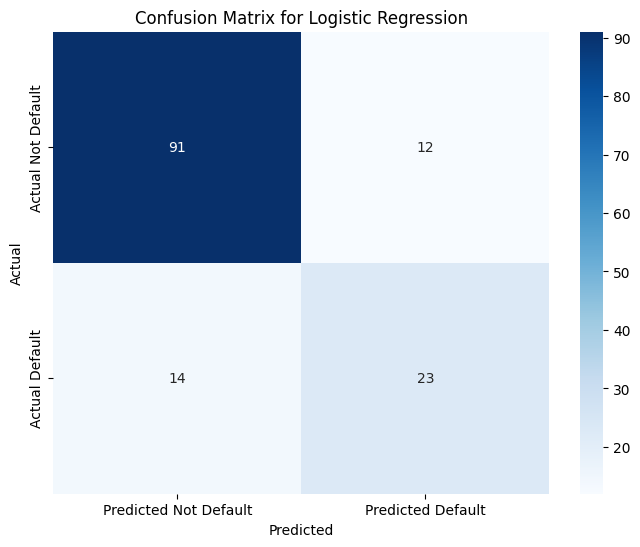

--- Training and Evaluating: Support Vector Machine ---
Best parameters found via GridSearchCV: {'C': 0.8, 'gamma': 0.1, 'kernel': 'linear'}
Support Vector Machine model has been trained.

Model Accuracy on Test Data: 83.57%

Classification Report:
                 precision    recall  f1-score   support

Not Default (0)       0.86      0.92      0.89       103
    Default (1)       0.73      0.59      0.66        37

       accuracy                           0.84       140
      macro avg       0.80      0.76      0.77       140
   weighted avg       0.83      0.84      0.83       140

--- Training and Evaluating: Random Forest ---
Random Forest model has been trained.

Cross-Validation Scores: [0.78571429 0.82142857 0.80357143 0.71428571 0.80357143 0.80357143
 0.83928571 0.75       0.82142857 0.78571429]
Average CV Score: 79.29%

Model Accuracy on Test Data: 83.57%

Classification Report:
                 precision    recall  f1-score   support

Not Default (0)       0.86      0.92  

In [100]:
# Store predictions to add them to the DataFrame later
predictions = {}

for name, model in models.items():
    print(f"--- Training and Evaluating: {name} ---")

    best_model = model # Default to the original model

    # --- Special handling for SVM with GridSearchCV ---
    if name == "Support Vector Machine":
        param_grid = {
            'C':[0.1,0.2,0.4,0.8,1.2,1.8,4.0,7.0],
            'gamma':[0.1,0.4,0.8,1.0,2.0,3.0],
            'kernel':['rbf','linear']
        }
        grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, refit=True, verbose=0, cv=10)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters found via GridSearchCV: {grid_search.best_params_}")

    # --- Train the final model ---
    if name != "Support Vector Machine": # SVM is already fit by GridSearchCV
        best_model.fit(X_train_scaled, y_train)

    print(f"{name} model has been trained.")

    # --- Special handling for Random Forest with Cross-Validation ---
    if name == "Random Forest":
        # Perform cross-validation on the training data to get a robust performance estimate
        cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10)
        print(f"\nCross-Validation Scores: {cv_scores}")
        print(f"Average CV Score: {np.mean(cv_scores):.2%}")

    # --- Evaluate the final model on the test set ---
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy on Test Data: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)']))

    # --- Generate and display detailed results for Logistic Regression only ---
    if name == "Logistic Regression":
    # --- Display Model Coefficients ---
        print("\nLogistic Regression Coefficients:")
        coeffs = pd.DataFrame(
            best_model.coef_[0],
            index=X.columns,
            columns=['Coefficient']
        ).sort_values(by='Coefficient', ascending=False)
        print(coeffs)
        print("\n(Positive coefficients increase the likelihood of default, Negative coefficients decrease it.)")

    # --- Generate and display the Confusion Matrix Heatmap ---
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Not Default', 'Predicted Default'],
                    yticklabels=['Actual Not Default', 'Actual Default'])
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # --- Predict the missing values in the unlabeled data ---
    unlabeled_predictions = best_model.predict(X_unlabeled_scaled)
    # Add the predictions to the original df DataFrame for the unlabeled rows
    # Make sure the index aligns correctly
    df.loc[unlabeled_df.index, f'predicted_default_{name.replace(" ", "_")}'] = unlabeled_predictions.astype(int)

In [101]:
# --- 6. Display Final Results ---
print("\n All models trained and predictions completed.")
print("Displaying the first 10 rows of the original dataframe with new prediction columns.")
print("Scroll right to see the new columns for rows where 'default' was originally NaN.")


 All models trained and predictions completed.
Displaying the first 10 rows of the original dataframe with new prediction columns.
Scroll right to see the new columns for rows where 'default' was originally NaN.


In [102]:
# Inspecting the rows that were originally null
print("\nInspecting rows where 'default' was originally NaN:")
print(df[df['default'].isna()].head(10))


Inspecting rows where 'default' was originally NaN:
     age  ed  employ  address  income  debtinc   creddebt    othdebt  default  \
700   36   1      16       13      32     10.9   0.544128   2.943872      NaN   
701   50   1       6       27      21     12.9   1.316574   1.392426      NaN   
702   40   1       9        9      33     17.0   4.880700   0.729300      NaN   
703   31   1       5        7      23      2.0   0.046000   0.414000      NaN   
704   29   1       4        0      24      7.8   0.866736   1.005264      NaN   
705   25   2       1        3      14      9.9   0.232848   1.153152      NaN   
706   34   1       4        3      28      9.4   1.058064   1.573936      NaN   
707   50   1      30        8     150     32.5  13.552500  35.197500      NaN   
708   27   1       5        5      26      1.2   0.130416   0.181584      NaN   
709   31   4       7       12      97      6.0   1.827480   3.992520      NaN   

     predicted_default_Logistic_Regression  \
700      

In [103]:
# --- 7. Compare Model Predictions on Unlabeled Data ---

print("\n--- Comparing Model Predictions on Unlabeled Data ---")

# Select the prediction columns for the unlabeled data
prediction_cols = [col for col in df.columns if col.startswith('predicted_default_')]
unlabeled_predictions_df = df[df['default'].isna()][prediction_cols]

# Display the first few rows of predictions for the unlabeled data
print("\nFirst 5 rows of predictions for unlabeled data:")

display(unlabeled_predictions_df.head(5))

# Compare predictions across models
if len(prediction_cols) >= 2:
    print("\nComparison of predictions:")
    # Check where all models agree
    all_agree = (unlabeled_predictions_df.nunique(axis=1) == 1).sum()
    print(f"Number of rows where all models agree on the prediction: {all_agree}")

    # Check where at least two models disagree
    at_least_one_disagree = len(unlabeled_predictions_df) - all_agree
    print(f"Number of rows where at least two models disagree on the prediction: {at_least_one_disagree}")

    # You could also do pairwise comparisons if desired
    if len(prediction_cols) == 3:
        lr_svm_agree = (unlabeled_predictions_df['predicted_default_Logistic_Regression'] == unlabeled_predictions_df['predicted_default_Support_Vector_Machine']).sum()
        lr_rf_agree = (unlabeled_predictions_df['predicted_default_Logistic_Regression'] == unlabeled_predictions_df['predicted_default_Random_Forest']).sum()
        svm_rf_agree = (unlabeled_predictions_df['predicted_default_Support_Vector_Machine'] == unlabeled_predictions_df['predicted_default_Random_Forest']).sum()

        print(f"\nPairwise agreement:")
        print(f"Logistic Regression and SVM agree on {lr_svm_agree} predictions.")
        print(f"Logistic Regression and Random Forest agree on {lr_rf_agree} predictions.")
        print(f"SVM and Random Forest agree on {svm_rf_agree} predictions.")

else:
    print("Not enough models to compare predictions.")


--- Comparing Model Predictions on Unlabeled Data ---

First 5 rows of predictions for unlabeled data:


,predicted_default_Logistic_Regression,predicted_default_Support_Vector_Machine,predicted_default_Random_Forest
700,0.0,0.0,0.0
701,0.0,0.0,0.0
702,1.0,1.0,1.0
703,0.0,0.0,0.0
704,0.0,0.0,0.0



Comparison of predictions:
Number of rows where all models agree on the prediction: 414
Number of rows where at least two models disagree on the prediction: 36

Pairwise agreement:
Logistic Regression and SVM agree on 438 predictions.
Logistic Regression and Random Forest agree on 414 predictions.
SVM and Random Forest agree on 426 predictions.
